[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brightbandtech/nnja-ai/blob/main/example_notebooks/basic_dataset_example.ipynb)

### Finding, subsetting, and loading data in the NNJA-AI archive

This notebook shows a simple workflow to find a dataset, subset to a time/variable range of interest, and then fetch and plot the data.

In [1]:
from nnja.io import _check_authentication
if _check_authentication():
    from nnja import DataCatalog

### DataCatalog
The `DataCatalog` holds references to all the datasets in the NNJA-AI archive, and can be searched (basic searching through names/strings/descriptions of datasets); datasets can be accessed though standard dictionary indexing, using the dataset name. 

In [2]:
catalog = DataCatalog(skip_manifest=True)  # skip_manifest=True avoids scanning GCS for dataset contents, just a bit faster
print("catalog json:", catalog.json_uri)
print("datasets in catalog:")
catalog.list_datasets()

catalog json: gs://nnja-ai/data/v1-preview/catalog.json
datasets in catalog:


['amsua-1bamua-NC021023',
 'atms-atms-NC021203',
 'mhs-1bmhs-NC021027',
 'cris-crisf4-NC021206',
 'iasi-mtiasi-NC021241']

In [3]:
catalog.search('amsu')

[NNJADataset(name='amsua-1bamua-NC021023', description='AMSU-A Level 1B brightness temperature data from NOA3-15,-16,-17,-18, -19 (ATOVS), METOP-2,-1)']

In [4]:
amsu_ds = catalog['amsua-1bamua-NC021023']
amsu_ds.load_manifest()
type(amsu_ds)

nnja.dataset.NNJADataset

### NNJADataset

A `NNJADataset` object represents a dataset for a single sensor/source/message. It is a light abstraction around an underlying parquet dataset stored on GCS. A user can either use this library to directly access those parquets (the URIs of which can be accessed using `dataset.manifest`), or can explore/subset the dataset time ranges and variables.

A straightforward workflow might be to select a dataset, (lazily) select a time range, select variables of interest, and then load the data using pandas, dask, or polars. 

In [5]:
print(amsu_ds.info())

Dataset 'amsua-1bamua-NC021023': AMSU-A Level 1B brightness temperature data from NOA3-15,-16,-17,-18, -19 (ATOVS), METOP-2,-1
Tags: amsu, brightness temperature, satellite, METOP, NOAA
Files: 1339 files in manifest
Variables: 49


In [6]:
print(amsu_ds.manifest.file)

OBS_DATE
2021-01-01 00:00:00+00:00    gs://nnja-ai/data/v1-preview/amsua/1bamua/NC02...
2021-01-02 00:00:00+00:00    gs://nnja-ai/data/v1-preview/amsua/1bamua/NC02...
2021-01-03 00:00:00+00:00    gs://nnja-ai/data/v1-preview/amsua/1bamua/NC02...
2021-01-04 00:00:00+00:00    gs://nnja-ai/data/v1-preview/amsua/1bamua/NC02...
2021-01-05 00:00:00+00:00    gs://nnja-ai/data/v1-preview/amsua/1bamua/NC02...
                                                   ...                        
2024-08-27 00:00:00+00:00    gs://nnja-ai/data/v1-preview/amsua/1bamua/NC02...
2024-08-28 00:00:00+00:00    gs://nnja-ai/data/v1-preview/amsua/1bamua/NC02...
2024-08-29 00:00:00+00:00    gs://nnja-ai/data/v1-preview/amsua/1bamua/NC02...
2024-08-30 00:00:00+00:00    gs://nnja-ai/data/v1-preview/amsua/1bamua/NC02...
2024-08-31 00:00:00+00:00    gs://nnja-ai/data/v1-preview/amsua/1bamua/NC02...
Name: file, Length: 1339, dtype: object


#### Time subsetting
Datasets can be subset in time using slice, list, or single value datetimes or strings castable with pd.to_datetime(); this is just convenience for subsetting on the dataset.manifest.

In [7]:
amsu_ds = amsu_ds.sel(time=slice('2021-01-01', '2021-01-01'))
ds2 = amsu_ds.sel(time='2021-01-01')
ds3 = amsu_ds.sel(time=['2021-01-01'])

assert ds2.manifest.equals(ds3.manifest) and ds2.manifest.equals(amsu_ds.manifest)

/Users/hans/code/nnja-ai/src/nnja/dataset.py:314: UserWarning: Naive datetime 2021-01-01 00:00:00 assumed to be in UTC
  warnings.warn(f"Naive datetime {dt} assumed to be in UTC", UserWarning)
/Users/hans/code/nnja-ai/src/nnja/dataset.py:314: UserWarning: Naive datetime 2021-01-01 00:00:00 assumed to be in UTC
  warnings.warn(f"Naive datetime {dt} assumed to be in UTC", UserWarning)


#### Variable subsetting

Datasets in the NNJA-AI archive may contain dozens or hundreds of individual variables, each representing a column of the underlying parquet dataset. These can be accessed directly using dataset.variables. Variables are grouped into 4 categories: __primary data__ (e.g. `brightness temeperature`), __secondary data__ (e.g. `standard deviation of brightness temperature`), __primary descriptors__ (e.g. `latitude`), and __secondary descriptors__ (e.g. `field of view number`). These groupings are a *subjective* assignment based on whether the data represents something about the world vs. something about the observer, and whether the data is important or not. 

Depending on the engine used to load data, early subsetting by variables can significantly increase load times; of course, you can also load the data and subset columns directly.

In [8]:
list(amsu_ds.variables.values())

[NNJAVariable("MSG_TYPE" (secondary descriptors), Source message type),
 NNJAVariable("MSG_DATE" (secondary descriptors), Message valid timestamp),
 NNJAVariable("MSG_IDX" (secondary descriptors), Message index in source file),
 NNJAVariable("SUBSET_IDX" (secondary descriptors), Subset index in source file and message),
 NNJAVariable("SRC_FILENAME" (secondary descriptors), Source filename),
 NNJAVariable("LAT" (primary descriptors), Latitude of the observation (coarse accuracy)),
 NNJAVariable("LON" (primary descriptors), Longitude of the observation),
 NNJAVariable("SAID" (primary descriptors), Satellite Identifier. Code table: https://www.nco.ncep.noaa.gov/sib/jeff/CodeFlag_0_STDv31_LOC7.html#001007),
 NNJAVariable("SIID" (secondary descriptors), Sensor Identifier. Code table: https://www.nco.ncep.noaa.gov/sib/jeff/CodeFlag_0_STDv31_LOC7.html#002019),
 NNJAVariable("FOVN" (secondary descriptors), Field of view number),
 NNJAVariable("LSQL" (secondary descriptors), Land/sea qualifier)

In [9]:
plot_col = 'TMBR_00001'
amsu_ds_sub = amsu_ds.sel(variables=['LAT', 'LON', plot_col])
print(amsu_ds_sub.info())

Dataset 'amsua-1bamua-NC021023': AMSU-A Level 1B brightness temperature data from NOA3-15,-16,-17,-18, -19 (ATOVS), METOP-2,-1
Tags: amsu, brightness temperature, satellite, METOP, NOAA
Files: 1 files in manifest
Variables: 3


This dataset now contains only one parquet partition (for the selected date) and 3 variables, so should be very fast to load, even using a tabular data tool that doesn't do lazy loading such as pandas. So let's load it and plot a day of data:

In [10]:
df = amsu_ds_sub.load_dataset(engine='pandas')

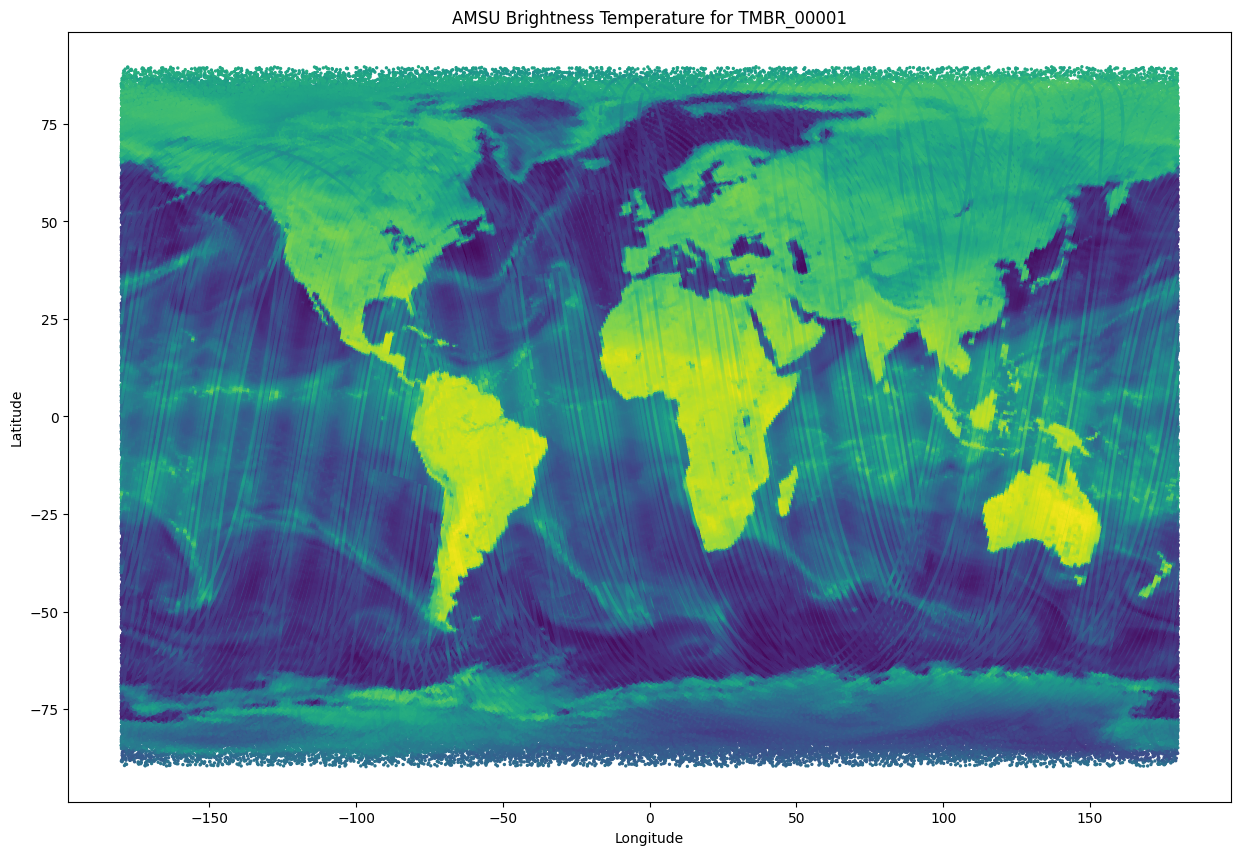

In [11]:
import matplotlib.pyplot as plt

def plot_df(df, plot_col):
    fig, ax = plt.subplots(figsize=(15, 10))
    subsample = 2
    ax.scatter(df['LON'][::subsample], df['LAT'][::subsample], s=2, c=df[plot_col][::subsample], cmap='viridis')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'AMSU Brightness Temperature for {plot_col}')
    plt.show()
plot_df(df, plot_col)

Compressing all that down, this is what it takes to open a dataset, slice it down to just the subset of interest, load that locally, and plot it:

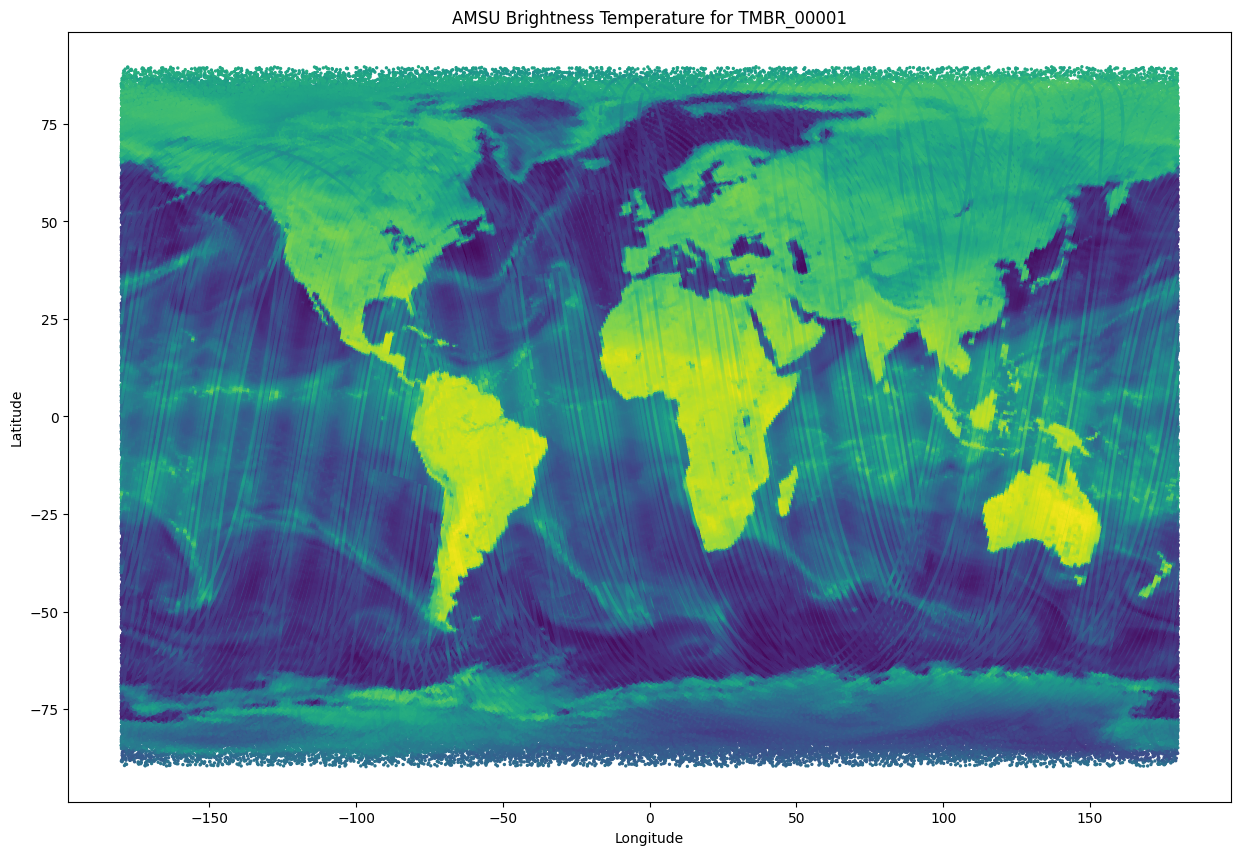

In [12]:
from nnja import DataCatalog
catalog = DataCatalog(skip_manifest=True)
amsu_ds = catalog['amsua-1bamua-NC021023'].load_manifest().sel(
    time='2021-01-01 00Z',
    variables=['LAT', 'LON', 'TMBR_00001']
)
df = amsu_ds.load_dataset(engine='pandas')
plot_df(df, 'TMBR_00001')